In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,  KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [36]:
# EDA
data = pd.read_csv('train.csv')
print(data.shape)
data.head(3)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


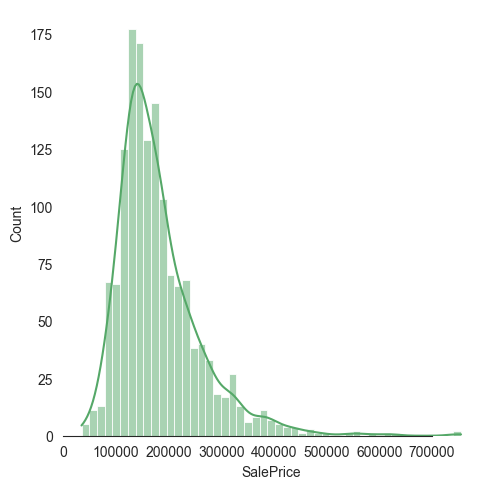

In [ ]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
# Check the new distribution 
sns.displot(data['SalePrice'], color="g", kde=True)
sns.despine(trim=True, left=True)

In [37]:
data.drop('Id', axis = 1, inplace=True)

# drop all columns with >= 50% NaN values
threshold = len(data) * 0.5
cols_to_drop = data.columns[data.isnull().sum() >= threshold]
data.drop(cols_to_drop, axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)

print("Columns missing at least 50 percent of values:\n", cols_to_drop)
print(data.shape)

Columns missing at least 50 percent of values:
 Index(['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')
(1460, 75)


In [ ]:
# Which variables are of type object? These will be transformed using dummy variables. 
# This will increase the column dimension of our dataframe, but we have enough samples that this shouldn't be an issue for modeling
object_columns = data.select_dtypes(include=['object']).columns
print("Object Columns:\n", object_columns)

# Make dummies
data_dummied = pd.get_dummies(data, columns=object_columns, drop_first=True)
data_dummied.reset_index(drop=True, inplace=True)

X = data_dummied.drop(columns='SalePrice', axis=1)
y = data_dummied['SalePrice']
y = np.log(y)

# Normalize the entire new dataframe column wise
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=data_dummied.columns)

# We will use the train data set as provided by Kaggle are our main data, and use the test set provided by Kaggle as a validation set

# Check missing data
null_counts = X.isnull().sum()
null_columns = null_counts[null_counts > 0]

# Printing the columns and their respective null value counts
print("Columns that contain missing values:")
for column, null_count in null_columns.items():
    print(f"Column: {column}, Column type: {X[column].dtype}, Null Values: {null_count}")

print("Missing values in y:", y.isnull().sum())

# Median imputation
missing_cols = X.columns[X.isnull().any()]
imputer = SimpleImputer(strategy='median')
X[missing_cols] = imputer.fit_transform(X[missing_cols])

Object Columns:
 Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')
Columns that contain missing values:
Column: LotFrontage, Column type: float64, Null Values: 259
Column: MasVnrArea, Column type: float64, Null Values: 8
Column: GarageYrBlt, Column type: float64, Null Values: 81
Missing values in y: 0


In [41]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize train and test sets independently
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X_test.columns)

Evaluation functions

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)

    # rmse = root_mean_squared_error(test_labels, predictions)
    rmse_log = np.sqrt(np.mean((np.log(predictions) - np.log(test_labels)) ** 2))
    mae = mean_absolute_error(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)

    # Printing regression metrics
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Squared Error Log: {:.2f}'.format(rmse_log))
    print('R^2 Score: {:.2f}'.format(r2)) 

Random Forest

In [ ]:
# For later comparison to determine if grid search improved performace
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train_normalized_df, y_train)
print('Base model metrics:')
base_accuracy = evaluate(base_model, X_test_normalized_df, y_test)

# Parameters grid for GridSearch
param_grid = {
    'n_estimators': [100, 200, 300, 1000],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [80, 100, 150, 200, 300],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create and train the random forest regressor using GridSearchCV with 5-fold cross validation
model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train_normalized_df, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Get test performance measures from best estimator
best_rf_model = grid_search.best_estimator_ 
print("Grid search model metrics:")
evaluate(best_rf_model, X_test, y_test)

# Average RMSE across the folds
cv_scores = grid_search.cv_results_['mean_test_score']
cv_rmse = (-cv_scores.mean()) ** 0.5
print(f'Cross-Validated RMSE: {cv_rmse}')

Mean Absolute Error: 0.24
Root Mean Squared Error: 0.39
R^2 Score: 0.88
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best parameters: {'bootstrap': False, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Mean Absolute Error: 0.22
Root Mean Squared Error: 0.38
R^2 Score: 0.88
Cross-Validated RMSE: 0.4184770333850487


XGBoost

In [31]:
# Prepare the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Prepare the XGBRegressor
xgb_model = XGBRegressor(objective='reg:squarederror')

# Implement 10-fold cross-validation with grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train_normalized_df, y_train)

# Get the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score (negative MSE): {best_score}")

best_xgb_model = grid_search.best_estimator_
evaluate(best_xgb_model, X_test, y_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best Score (negative MSE): -0.11812151841404459
Mean Absolute Error: 0.35
Root Mean Squared Error: 0.45
R^2 Score: 0.83


In [ ]:
# median imputing

Gradient Boosting

In [42]:
# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize and perform 5 fold cross validation with a grid search for a gradient boosting regressor
gbr_regressor = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbr_regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters found by Grid Search:", grid_search.best_params_)

# Extract the best estimator
best_gbr_model = grid_search.best_estimator_
evaluate(best_gbr_model, X_test, y_test)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\rtesi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
290 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rtesi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rtesi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\rtesi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\bas

Best Parameters found by Grid Search: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.8}
Mean Absolute Error: 0.21
Root Mean Squared Error: 0.34
R^2 Score: 0.91


In [45]:
stacking_regressor = StackingRegressor(
    estimators=[
        ('rf', best_rf_model),
        ('xgb', best_xgb_model),
        ('grb', best_gbr_model)
    ],
    final_estimator=XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
)

# Fit the Stacking Regressor to the training data
stacking_regressor.fit(X_train, y_train)
evaluate(stacking_regressor, X_test, y_test)

Mean Absolute Error: 0.22
Root Mean Squared Error: 0.40
R^2 Score: 0.87


Attempting better performance:

In [ ]:
kfold = KFold(n_splits=12, random_state=42, shuffle=True)